In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
%output size = 150


def qhe_corbino(r_out=100, r_in=65, w_lead=10):
    """Create corbino disk. 

    Square lattice, one orbital per site.
    Returns kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead, B, phi
    """
    # ring shape
    def ring(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return (r_in ** 2 < rsq < r_out ** 2)

    # Onsite and hoppings
    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def crosses_branchcut(hop):
        x1, y1 = hop[0].pos
        x2, y2 = hop[1].pos
        return y1 < 0 and x1 > 0.5 and x2 < 0.5

    def hopping(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        # Check for correctness!
        return -p.t * np.exp(-0.5j * p.B * (x1 - x2) * (y1 + y2))

    def branchcut_hopping(site1, site2, p):
        return hopping(site1, site2, p) * np.exp(1j * p.phi)

    # Building system
    lat = kwant.lattice.square()
    sys = kwant.Builder()

    sys[lat.shape(ring, (0, r_in + 1))] = onsite
    sys[lat.neighbors()] = hopping

    # adding special hoppings
    def hops_across_cut(sys):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(sys):
            if crosses_branchcut(hop):
                yield hop
    sys[hops_across_cut] = branchcut_hopping

    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (-w_lead / 2 < y < w_lead / 2)

    lead[lat.shape(lead_shape, (0, 0))] = lambda site, p: 4 * p.t - p.mu_lead
    lead[lat.neighbors()] = lambda site1, site2, p: -p.t

    #### Attach the leads and return the system. ####
    sys.attach_lead(lead)
    sys.attach_lead(lead, origin=lat(0, 0))

    return sys


def total_charge(value_array):
    determinants = [np.linalg.det(s) for s in value_array]
    charge = np.cumsum(np.angle(determinants / np.roll(determinants, 1)))
    return charge / (2 * np.pi)


def qhe_ribbon(W, periodic=False):
    """ Creates ribbon system

    If we have periodic boundary conditions, the flux through a single 
    unit cell is quantized.
    """
    W = 2 * (W // 2)

    def ribbon_shape(pos):
        (x, y) = pos
        return (-W / 2 <= y <= W / 2)

    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def hopping(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -p.t * np.exp(-0.5j * p.B * (x1 - x2) * (y1 + y2))

    def hopping_periodic(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -p.t * np.exp(-1j * np.pi / (W + 1) * np.round((W + 1) * p.B / (2 * np.pi)) * (x1 - x2) * (y1 + y2))

    lat = kwant.lattice.square()
    sym_sys = kwant.TranslationalSymmetry((-1, 0))
    sys = kwant.Builder(sym_sys)

    sys[lat.shape(ribbon_shape, (0, 0))] = onsite

    if periodic:
        sys[lat.neighbors()] = hopping_periodic
        sys[lat(0, - W / 2), lat(0, + W / 2)] = hopping_periodic
    else:
        sys[lat.neighbors()] = hopping

    return sys

# Quantum hall bar codes


def qhe_hall_bar(L=50, W=10, w_lead=10, w_vert_lead=None):
    """Create a hall bar system. 

    Square lattice, one orbital per site.
    Returns kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead
    """

    L = 2 * (L // 2)
    W = 2 * (W // 2)
    w_lead = 2 * (w_lead // 2)
    if w_vert_lead is None:
        w_vert_lead = w_lead
    else:
        w_vert_lead = 2 * (w_vert_lead // 2)

    # bar shape
    def bar(pos):
        (x, y) = pos
        return (x >= -L / 2 and x <= L / 2) and (y >= -W / 2 and y <= W / 2)

    # Onsite and hoppings
    def onsite(site, p):
        (x, y) = site.pos
        return 4 * p.t - p.mu

    def hopping_Ax(site1, site2, p):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -p.t * np.exp(-0.5j * p.B * (x1 + x2) * (y1 - y2))

    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, p):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            return -p.t * np.exp(-1j * p.B * x0 * (y1 - y2))
        return hopping_Ay

    def lead_hop_vert(site1, site2, p):
        return -p.t

    # Building system
    lat = kwant.lattice.square()
    sys = kwant.Builder()

    sys[lat.shape(bar, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_Ax

    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (-w_lead / 2 <= y <= w_lead / 2)

    lead_onsite = lambda site, p: 4 * p.t - p.mu_lead

    sym_lead_vertical = kwant.TranslationalSymmetry((0, 1))
    lead_vertical1 = kwant.Builder(sym_lead_vertical)
    lead_vertical2 = kwant.Builder(sym_lead_vertical)

    def lead_shape_vertical1(pos):
        (x, y) = pos
        return (-L / 4 - w_vert_lead / 2 <= x <= -L / 4 + w_vert_lead / 2)

    def lead_shape_vertical2(pos):
        (x, y) = pos
        return (+L / 4 - w_vert_lead / 2 <= x <= +L / 4 + w_vert_lead / 2)

    lead_vertical1[lat.shape(lead_shape_vertical1, (-L / 4, 0))] = lead_onsite
    lead_vertical1[lat.neighbors()] = lead_hop_vert
    lead_vertical2[lat.shape(lead_shape_vertical2, (L / 4, 0))] = lead_onsite
    lead_vertical2[lat.neighbors()] = lead_hop_vert

    sys.attach_lead(lead_vertical1)
    sys.attach_lead(lead_vertical2)

    sys.attach_lead(lead_vertical1.reversed())
    sys.attach_lead(lead_vertical2.reversed())

    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(-L / 2)

    sys.attach_lead(lead)

    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L / 2)

    sys.attach_lead(lead.reversed())

    return sys


def calculate_sigmas(G):
    # reduce by one dimension G -> G[temp, temp]
    temp = [0, 1, 3, 4, 5]
    G = G[temp, :]
    G = G[:, temp]
    # invert R = G^-1
    # find out whether it is a numpy object
    r = np.linalg.inv(G)
    # Voltages follow: V = R I[temp]
    V = r.dot(np.array([0, 0, 0, 1, -1]))
    # Completely solved the six terminal system.
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[1] - V[0]
    E_y = V[1] - V[3]
    # formula above
    sigma_xx = E_x / (E_x**2 + E_y**2)
    sigma_xy = E_y / (E_x**2 + E_y**2)
    return sigma_xx, sigma_xy


def plot_pumping(sys, p):
    p.mu_lead = p.mu
    phis = np.linspace(0, 2 * np.pi, 40)
    sys = sys.finalized()
    rs = [kwant.smatrix(sys, energy=0.0, args=[p]).submatrix(1, 1) for p.phi in phis]
    charges = -total_charge(rs)
    style = {'xticks': [0, 1], 'yticks': [0, 1, 2, 3], 'aspect': 'square'}
    kdims = ['$\phi/2\pi$', '$q_{pump}$']
    title = '$\mu = {:.2}$, $\sigma_H = {:} \cdot e^2/h$'.format(p.mu, int(charges[-1]))
    return holoviews.Path((phis / (2 * np.pi), charges), kdims=kdims, label=title)(plot=style)[:, 0:3.1]


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

## We present an argument for the robustness of the quantum hall effect for electrons: Laughlin argument
* Observation of Quantum Hall
* Quantized Hall conductance from pumping: Laughlin argument
* Landau levels: microscopic model for the quantum hall effect

# Introduction

Ady Stern from the Weizmann Institute of Science will introduce the quantum Hall effect.

Ady thanks Dr. Dan Arav and Gil Novik from the School of Media Studies of the
College of Management - Academic Studies for their help in preparing the videos.

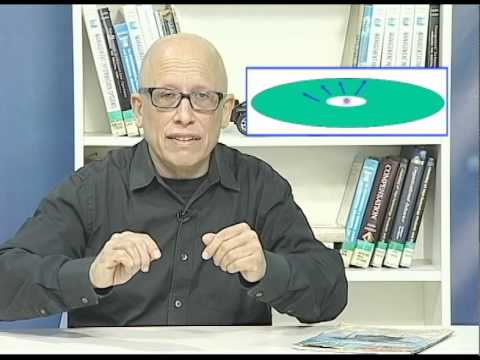

In [2]:
MoocVideo("QC3tQT7MD00", src_location='3.2-intro', res='360')

# The Hall effect

We now move on to the quantum Hall effect, the mother of all topological effects in condensed matter physics.

But let's start from the classical [Hall effect](http://en.wikipedia.org/wiki/Hall_effect), the famous phenomenon by which a current flows perpendicular to an applied voltage, or vice versa a voltage develops perpendicular to a flowing current.

How does one get a Hall effect? The key is to break time-reversal symmetry. A flowing current breaks time-reversal symmetry, while an electric field doesn't. Hence, any system with a Hall effect must somehow break time-reversal symmetry.

But wait a minute, you might catch me and ask, what about a normal electric current flowing parallel to an electric field? This is what happens in a metal on a regular basis, and a metal does not break time-reversal symmetry.

The key difference there is that such a longitudinal current breaks time-reversal through energy dissipation, which turns into heat that breaks time-reversal by the second law of thermodynamics. A Hall current is special in that it is **dissipationless**. We can drive a Hall current without wasting any energy because the current flows perpendicular to the voltage gradient.

> Thus to get a Hall effect we must somehow break time-reversal symmetry. We will examine the simplest way to achieve this, an external magnetic field.

## How to measure the Hall effect

Let's consider a two dimensional gas of electrons immersed in a strong, perpendicular magnetic field. In particular, we take the following geometry, which is called a Hall bar and is routinely used in experiments:

![](figures/hall_bar.svg)

The electron gas is contacted by six electrodes, numbered in the figure. We can use this Hall bar geometry set-up to measure the transport characteristics of the gas, as follows.

The transport characteristics are tabulated using the 4 components $\sigma_{xx},\sigma_{yy},\sigma_{xy}$ and $\sigma_{yx}$ of the so-called conductivity tensor. Once we know the conductivity tensor, we can use it to calculate how the current density $\mathbf{j} = (j_x,j_y)$ flows in response to the electric field $\mathbf{E} = (E_x,E_y)$ in the metal, through the equation  

$$j_\alpha=\sum_\beta \sigma_{\alpha\beta}E_{\beta}.$$

By inverting this set of relations between current densities and electric field, we obtain the resistivities $\rho_{xx}, \rho_{xy}, \dots$, which are more often reported in experimental data. Also, in two-dimensional systems there is no real difference between conductance and conductivity (or resistance and resistivity) - they have the same physical units. So the terms are somehow interchangeable.

The way to use the Hall bar device is to drive a current $I$ along the $x$ direction, so that there is a current density $j_x=(I/W)$ where $W$ is the width of the sample. There is no current density in the perpendicular direction.

We can measure the electric field using the Hall bar geometry from the voltage drops between the probes with voltages $V_{1,2,3,4}$.
We can then measure the $x$-component of the electric field from the longitudinal voltage drop $V_L\sim (V_1-V_2)$ or  $(V_3-V_4)$ according to the averaged equation 

$$E_x \equiv \frac{V_1+V_3-V_2-V_4}{2L}.$$

Similarly, we can measure the $y$-component of the electric field from the  Hall voltage $V_H=(V_1-V_3)$ or $(V_2-V_4)$. Specifically we can calculate the electric field as: 

$$E_y \equiv \frac{V_1+V_2-V_4-V_3}{2L}.$$


The Hall bar can only measure the conductance completely for isotropic or rotationally invariant systems. Clearly, if we rotate the system by 90 degrees we can transform $x\rightarrow y$ and $y\rightarrow -x$. So we expect $\sigma_{xx}=\sigma_{yy}=\sigma_L$, which is referred to as the longitudinal conductance. If we apply this same rotation transformation we conclude that $\sigma_{xy}=-\sigma_{y x}=\sigma_H$, which is referred to as the Hall conductance. 

So with rotational invariance the 4 component conductance tensor has only 2 independent components i.e. the longitudinal and Hall conductance. We can calculate these using the two electric fields $E_{x,y}$ that we measure using the Hall bar. 
To do this, we solve the set of equations $j_y=\sigma_L E_y - \sigma_H E_x=0$ and $j_x=\sigma_L E_x+\sigma_H E_y$ to obtain $\sigma_{L,H}$. We obtain the Hall conductance

$$\sigma_H=\frac{j_x E_y}{E_x^2+E_y^2}.$$

# The classical Hall effect is a linear effect

Let's now try to obtain an alternative expression for the Hall conductance $\sigma_H$ of our Hall bar. In general we expect the electric and magnetic fields present in our Hall bar to apply a force to the electrons, and increase their velocity. 

Instead of solving the problem directly, let us make the ansatz that the electrons enter a state, which is obtained from the usual electron ground state by doing a Galilean transformation to a reference frame moving with velocity $\bf{v}$ with respect to the original reference frame.

Since the average velocity of the electrons is $\bf v$ in the original reference frame, the average force on the electrons is 

$${\bf F}= e\,(\mathbf{E}+\mathbf{v}\times \mathbf{B}).$$

If we want to be a steady state then $\bf F=0$, which means that ${\bf v}= (\mathbf{E}\times \mathbf{B})/B^2$. Since the electrons move with an average velocity $\bf v$, and if $n$ denotes the electron density, we can easily guess that the current density is ${\bf j}=n e {\bf v}=(n e/ B) \,(\mathbf{E}\times \mathbf{z})$.

> Comparing with the previous subsection, we can thus conclude that simply based on Galilean invariance, an electron gas in a magnetic field must have a Hall conductance that is given by 

$$\sigma_H=n e B^{-1}.$$

This relation, which says that $\sigma_H\propto n$, is extremely general in the sense that it does not depend on how the electrons interact with each other or anything else. It is referred to as the Streda relation. If we define the so-called "filling factor" as $\nu=n h/ e B$ the Hall conductance can be written as a multiple of the quantum of conductance as $\sigma_H=\nu \frac{e^2}{h}$.

As you already heard from Ady Stern in the intro video, people have measured the Hall conductance of this exact system to incredible precision. At relatively high density, the Hall conductance of this system behaves itself accordingly and scales linearly with gate voltage, which is tuned to control the density. At low filling factors, one would expect many non-idealities like disorder and interaction to break the Galilean invariance based argument and lead to a Hall conductance $\sigma_H$ that varies from sample to sample and depends on disorder. 

In [3]:
question = "What is the longitudinal conductance for the ideal electron gas in a magnetic field?"
answers = ["Infinity since there are no impurities in the system.",
           "Finite and inversely proportional to the magnetic field like the Hall conductance.",
           "Finite and proportional to density but independent of magnetic field.",
           "Zero since current is perpendicular to electric field."
           ]
explanation = "As we saw the velocity is related to the cross-product of the electric and magnetic field."
MoocMultipleChoiceAssessment(question, answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'question': 'What is the longitudinal conductance for the ideal electron gas in a magnetic field?', 'answers': ['Infinity since there are no impurities in the system.', 'Finite and inversely proportional to the magnetic field like the Hall conductance.', 'Finite and proportional to density but independent of magnetic field.', 'Zero since current is perpendicular to electric field.'], 'max_attempts': 2, 'display_name': 'Question', 'explanation': 'As we saw the velocity is related to the cross-product of the electric and magnetic field.', 'correct_answer': 3})

# The quantum Hall effect: experimental data

Instead, a completely unexpected result was measured for the first time by Klaus von Klitzing. Typical experimental data looks like this (taken from M.E. Suddards, A. Baumgartner, M. Henini and C. J. Mellor, [New J. Phys. 14 083015](http://iopscience.iop.org/1367-2630/14/8/083015)):

![](figures/QHE.png)

> As the average density is varied, the Hall conductance $\sigma_H$ appears to form plateaus at integer filling fractions $\nu=1,2,3,\dots$. These plateaus are incredibly sample independent and occur at the same value in many other materials. At the same time, the longitudinal conductivity appears to vanish except at the transition points between the plateaus. This is the integer "Quantum Hall effect". 

This setup is easy to try to reproduce numerically, but there's one complication:

:Overlay
   .Path.Reverse_over_sigma_left_curly_bracket_xx_right_curly_bracket :Path   [$B^{-1} [a.u.]$,$\sigma_{xx}, \sigma_{xy}\,[e^2/h]$]
   .Path.Reverse_over_sigma_left_curly_bracket_xy_right_curly_bracket :Path   [$B^{-1} [a.u.]$,$\sigma_{xx}, \sigma_{xy}\,[e^2/h]$]
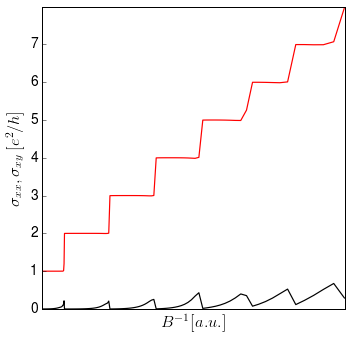

In [4]:
sys = qhe_hall_bar(L=60, W=100, w_lead=90, w_vert_lead=28).finalized()
p = SimpleNamespace(t=1.0, mu=0.3, mu_lead=0.3, B=None)
Bs = np.linspace(0.02, 0.15, 200)
num_leads = len(sys.leads)
def G(sys, p):
    smatrix = kwant.smatrix(sys, args=[p])
    G = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
    G -= np.diag(np.sum(G, axis=0))
    return calculate_sigmas(G)

sigmasxx, sigmasxy = np.array([G(sys, p) for p.B in Bs]).T

kdims = [r'$B^{-1} [a.u.]$', '$\sigma_{xx}, \sigma_{xy}\,[e^2/h]$']
plot_xx = holoviews.Path((1/Bs, sigmasxx), label=r'$\sigma_{xx}$', kdims=kdims)(style={'color': 'k'})
plot_xy = holoviews.Path((1/Bs, sigmasxy), label=r'$\sigma_{xy}$', kdims=kdims)(style={'color': 'r'})

(plot_xx * plot_xy)(plot={'xticks': 0, 'yticks': list(range(8))})

Numerical systems are so good that the longitudinal conductivity always stays low even at the transition.

But other than that small problem everything works just the same.

# Quantized Hall conductance from pumping: Laughlin argument

Why is the quantized Hall conductance $\sigma_H$ so robust and independent of system details? Clearly there must be a topological argument at play.

Soon after the experimental discovery, Laughlin came up with an elegant argument that mapped the Hall conductance problem to a topological pumping problem and in the process explained the robustness. Let us go through this argument.

## The Corbino geometry

To start with, we imagine doing the Hall measurement in a system cut out as an annulus, which is referred to as the Corbino disk:

![](figures/corbino_flux.svg)

We will also try to do the experiment in reverse i.e. apply an electric field along the circumference of the disk and measure the current $I$ in the radial direction, as shown in the figure. The radial current is easy to measure - we just measure the amount of charge $\Delta Q$ transferred between the inner and outer edges of the Corbino geometry and obtain the radial current $I=\Delta Q/\Delta T$, where $\Delta T$ is the time over which this is done.

But how do we apply an electric field in the tangential direction?  The easiest way to do this is to apply a time-dependent magnetic field in the centre of the disc and use the Faraday effect. 

We can calculate the electric field from the changing magnetic field using Faraday's law as $\oint d{\bf{r}\cdot\bf{E}}=\partial_t \Phi$, where $\Phi$ is the magnetic flux resulting from the field in the center of the disk. Assuming that the electric field depends only on the radius $R$ we find that the resulting tangential electric field is given by

$$E(R,t)=\frac{1}{2\pi R}\,\partial_t \Phi.$$ 

Given $I$, we can also calculate the other component of the measurement of the Hall conductance $\sigma_H$ i.e. the radial current density $j=I/(2\pi R)$ at the same radius $R$ as we calculated the electric field. 

Now that we know both the circumferential electric field and also the radial current density, the Hall conductance can be measured easily in this geometry as 

$$\sigma_H=\frac{j}{E(r,t)}=\frac{I}{\partial_t \Phi}.$$

You might worry that we were a bit simplistic and ignored the longitudinal conductance in this geometry. We could measure the longitudinal conductivity by applying a voltage difference between the inner and outer edges and measuring the resulting radial current $I$. For the remainder of this discussion, we assume that the longitudinal conductivity vanishes as is observed experimentally.

## Laughlin pump

We are now ready to present the pumping argument to explain why the low temperature Hall effect is quantized.

To do this, we change the magnetic field in the center of the Corbino disc so that the flux changes by $\Delta \Phi=\Phi_0=h/e$, i.e. a **flux quantum** over the time $\Delta T$. (Note that this flux quantum is only half of the superconducting flux quantum that we were using last week. That's because now the current is being carried by electrons and not Cooper pairs. It is customary to use the same symbol $\Phi_0$ for both, since they often appear in different contexts). Assuming that we have a system with Hall conductance $\sigma_H$, we obtain the charge transferred as 

$$\Delta Q=I \Delta T=\sigma_H\, \Delta T\, \partial_t\Phi =\sigma_H\,\Delta\Phi=\sigma_H\, \frac{h}{e}.$$

Writing $\sigma_H=\nu e^2/h$, we obtain $\Delta Q=\nu e$. Since the longitudinal conductance $\sigma_L=0$, we expect the system to be gapped in the bulk of the disc and we expect the entire charge transfer $\Delta Q$ to occur between the edges.

>Since the flux $\Phi$ in the center is a flux quantum $\Phi_0$, the wave functions of the electrons all return to being the same as at $\Phi=0$. Therefore only an integer number of charges $\Delta Q=n e$ can be pumped between the edges. This is Laughlin's argument for why the Hall conductance must be quantized as

$$\sigma_{xy}=n e^2/h.$$

What you notice at this point is that we basically have a pump similar to the last unit.

Here an integer number of charges is pumped from one edge to the other as the flux $\Phi$ is increased by $\Phi_0$. As one sees below, one can simulate electrons in a Corbino geometry and check that indeed an integer number of charges is pumped between the edges as the flux $\Phi$ is changed by $\Phi_0$.



b':HoloMap   [$\\mu$]\n   :Path   [$\\phi/2\\pi$,$q_{pump}$]'
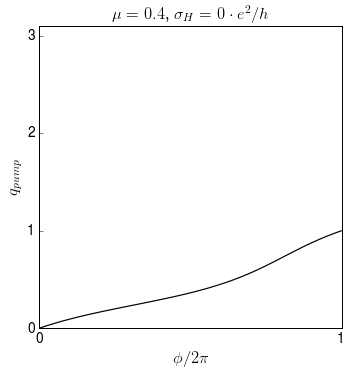
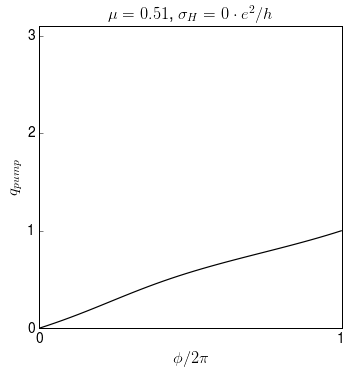
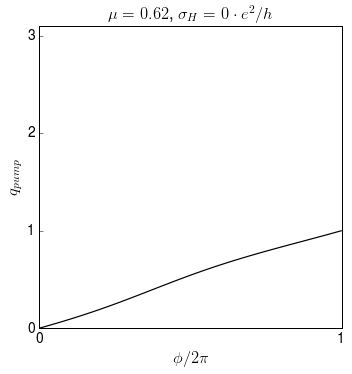
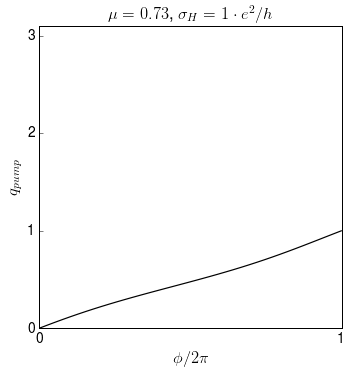
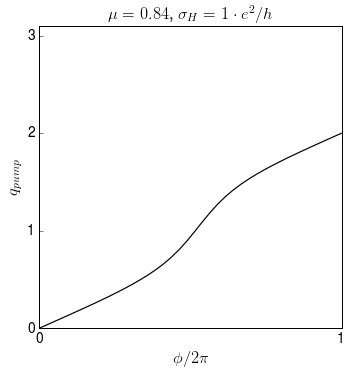
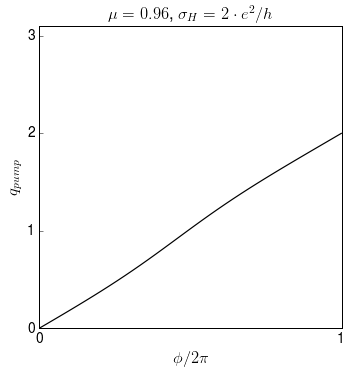
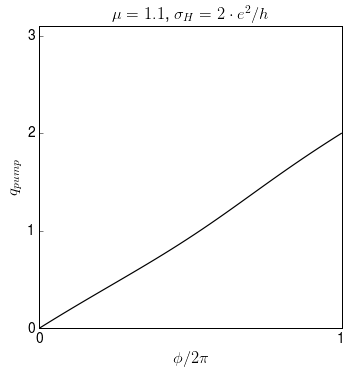
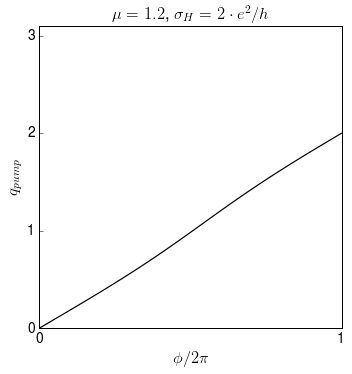
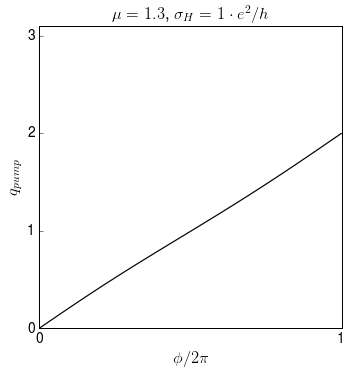
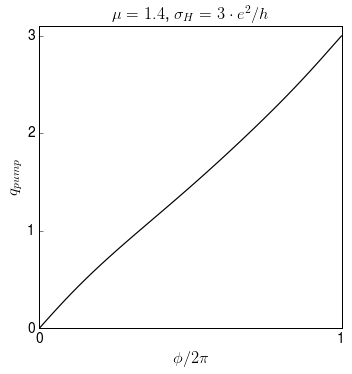

In [5]:
W = 20
p = SimpleNamespace(t=1, B=2*np.pi/(W+1), phi=None, mu=None)
sys = qhe_corbino(r_out=2*W, r_in=20, w_lead=10)
mus = np.linspace(0.4, 1.4, 10)
holoviews.HoloMap({p.mu: plot_pumping(sys, p) for p.mu in mus}, kdims=[r'$\mu$'])

In [6]:
question = ("Experimentally the quantum Hall conductance jumps - what does this mean about the "
            "robustness of the Laughlin pumping argument?")
answers = ["The Laughlin argument breaks down because it assumes specific values of the magnetic field.",
           "The Laughlin argument assumes there is no longitudinal conductivity.",
           "The Hall conductance is not a topological invariant since it changes.",
           "The flux in the corbino geometry was changed by a value that was not a multiple of the flux quantum."
           ]
explanation = ("The key ingredient in the Laughlin argument was that there is no states at the fermi level in "
               "the bulk which is equivalent to no longitudinal conductivity")
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'question': 'Experimentally the quantum Hall conductance jumps - what does this mean about the robustness of the Laughlin pumping argument?', 'answers': ['The Laughlin argument breaks down because it assumes specific values of the magnetic field.', 'The Laughlin argument assumes there is no longitudinal conductivity.', 'The Hall conductance is not a topological invariant since it changes.', 'The flux in the corbino geometry was changed by a value that was not a multiple of the flux quantum.'], 'max_attempts': 2, 'display_name': 'Question', 'explanation': 'The key ingredient in the Laughlin argument was that there is no states at the fermi level in the bulk which is equivalent to no longitudinal conductivity', 'correct_answer': 1})

# Landau levels: a microscopic model for the quantum hall effect

The general argument so far is great in that it applies to virtually any complicated electron system with interactions and in a real material, but we would probably feel better if we could calculate the Hall conductance directly for some simple system. So let us try to do this for the simplest case of electrons in a magnetic field.

For starters, let us forget about the Corbino disk and just ask what do quantum mechanical electrons do in a magnetic field. 

## Landau levels on the back of an envelope

We know what classical electrons do in a perpendicular magnetic field: They go around in *cyclotron orbits*, because of the Lorentz force. The cyclotron radius in a magnetic field of strength $B$ for an electron with velocity $v$ is $r_c = mv/eB$. An electron performing a cyclotron orbit at velocity $v$ has angular momentum $L=mvr_c=eB r^2_c$. In quantum mechanics, however, only orbits with a quantized angular momentum $L=n\hbar$ will be allowed. From the equality $r^2_c = n\hbar/eB$ one obtains that only some discrete values are allowed for the radius, $r_n = \sqrt{n} l_B$, where $l_B = \sqrt{\hbar/eB}$ is called the magnetic length.

All cyclotron orbits, independent of the radius, circle at the same frequency $\omega_c=eB/m$. The energy of the electron in this quantized orbit is equal to $L\omega_c = n\hbar\omega_c$. So the energy spectrum really looks like that of a harmonic oscillator. All the energy levels are also shifted up from zero energy by the zero-point motion of the harmonic oscillator, $\hbar\omega_c/2$. We finally obtain that the allowed energy levels are

$$E_n = \hbar \omega_c \,\left(n+\tfrac{1}{2}\right)\,.$$

These quantized energy levels of electrons in a magnetic field are called **Landau levels**.

You can put many electrons in the same Landau level: one for every flux quantum of the magnetic flux passing through the system. Therefore Landau levels have a huge degeneracy, proportional to the area of the sample.


## Landau levels from the Hamiltonian

Now that we know the answer in advance, we can solve the Schrödinger equation for electrons in a magnetic field without stress. It will still be important to understand the quantum Hall effect in a bit more detail. The Hamiltonian is

$$H=(\textbf{p}-e \textbf{ A})^2.$$ 

The vector potential $\bf{A}$ depends on position, which makes this Hamiltonian complicated to solve in general. For a uniform magnetic field, we can make our life easier by choosing a Landau gauge 

$$\textbf{A}(x,y)=\hat{\textbf{x}}B y ,$$ 

where the vector potential does not depend on $x$. In this gauge, the entire Hamiltonian is translationally invariant along the $x$ direction, and therefore commutes with the corresponding momentum $p_x$. This allows us to choose $p_x=\hbar k$ as a good quantum number, and our two dimensional Hamiltonian reduces to a one dimensional one:

$$H(k)=p_y^2+(\hbar k-e B y)^2.$$

Apart from a shift of the $y$ coordinate by $y_0(k)=\hbar k/eB$, this is exactly the Hamiltonian of a simple harmonic oscillator! Its eigenvalues are the Landau levels, which are independent of $k$. The corresponding wave functions are those of the harmonic oscillator along the $y$ direction, and plane waves with momentum $k$ along the $x$ direction. In the $y$ direction, they are localized in space within a length $\sim l_B$.

This gives us another way to understand the quantized Hall conductance for ideal two dimensional electron gases.

Now, the electron energies are quantized in Landau levels, and if $n$ Landau levels are filled at a given chemical potential, the filling factor is $\nu=n$. The Streda formula then predicts the Hall conductance as $\sigma_H=\nu e^2/h=n e^2/h$. The longitudinal conductivity must vanish since the gapped system does not allow dissipation of energy in the bulk.

# Flux pumping of electrons in a Hall cylinder

We can now see explicitly how the Laughlin pumping argument works, starting from the microscopic description of electrons in terms of Landau levels. Starting from the formulas we derived, it is a little difficult to do so in the Corbino geometry, which has an angular symmetry rather than a translational symmetry. It is very easy if we consider the Laughlin pump for electrons in a cylinder:

![](figures/hall_cylinder.svg)

In fact the cylinder drawn above and the Corbino disk are completely equivalent - you can imagine deforming one into the other. The advantage of the cylinder is that we get to keep our $(x, y)$ coordinates. The Hall cylinder that we considered for Laughlin's argument is in fact equivalent to a ribbon in the $(x, y)$ plane, with periodic boundary conditions $x\equiv x+L$ in the $x$ direction ($L$ is the circumference of the cylinder).
The periodic boundary conditions along the $x$ direction discretize the allowed values of $k$ as $k=2\pi n/L$.

For the Laughlin pumping argument, we need to introduce a flux through the cylinder. Using Stokes' theorem, we know that the line integral of the vector potential around the cylinder must be equal to the flux passing through it, $\oint \textbf{dr}\cdot\textbf{A(r)}=\Phi$. So we can introduce a flux through the cylinder by choosing our vector potential $\bf{A}$ as 

$$\textbf{A}(x,y)=(B y +\Phi/L)\,\hat{\textbf{x}}\,,$$ 

very similar to the previous calculation. The resulting Hamiltonian for the states labeled by $n$ is  

$$H=p_y^2+\left(\frac{\hbar 2\pi n}{L}-e B y-\frac{e\Phi}{L}\right)^2\,.$$


Comparing the above equation to the quantum harmonic oscillator, we see that the harmonic oscillator levels 
must be centered at 

$$y_0(n) = \left(n-\frac{\Phi}{\Phi_0}\right)\frac{h}{e B L}\,.$$

>We see from this that the Landau level wave-functions are centered around a discrete set of rings at $y_0(n)$ on the cylinder axis that are labelled by the integer $n$.  As $\Phi$ is increased we see that the centers $y_0$ move so that after one flux quantum $\Delta\Phi=\Phi_0=h/e$ all the electrons have moved down by one step along $y$, i.e. $n \rightarrow n-1$. If $n$ Landau levels are filled then a total charge of $\Delta Q=n e$ will be transferred between the edges, in exact accordance with the Laughlin argument.

We can now look again at the Laughlin pump, monitoring at the same time the Landau levels. You can see that the total pumped charge jumps in integer steps each time a Landau level passes through the Fermi level.

:Layout
   .HoloMap.Reverse_over_mu_equals_0_full_stop_4_comma_reverse_over_sigma_H_equals_1_reverse_over_cdot_e_power_2_over_h :HoloMap   [$\mu$]
      :Path   [$\phi/2\pi$,$q_{pump}$]
   .HoloMap.Landau_levels                                                                                               :HoloMap   [$\mu$]
      :Overlay
         .Path.Landau_levels :Path   [$k$,$E$]
         .HLine.I            :HLine   [x,y]
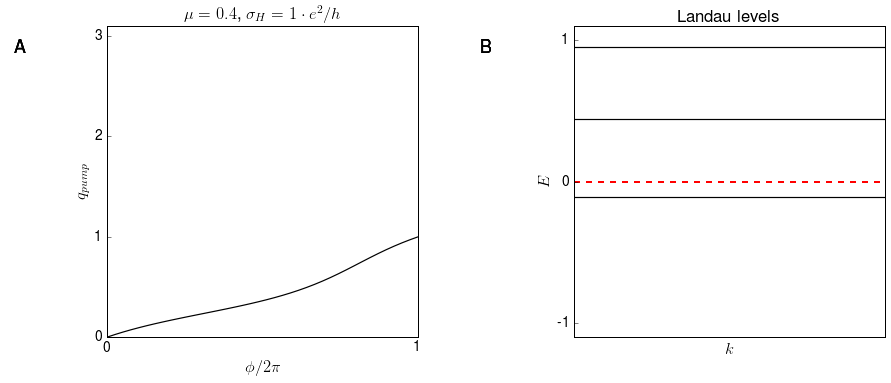
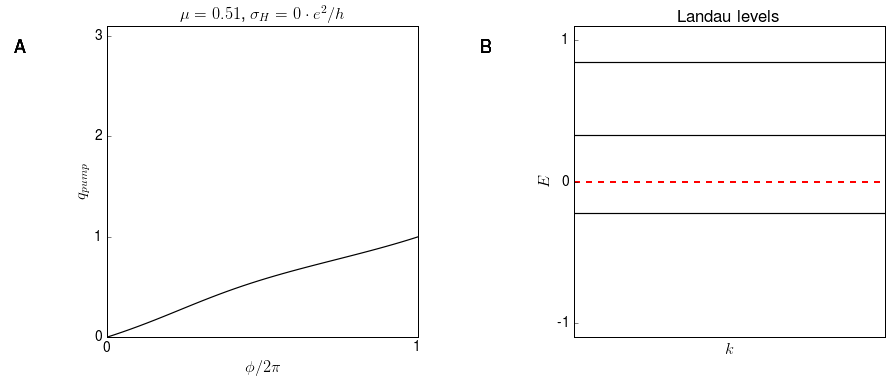
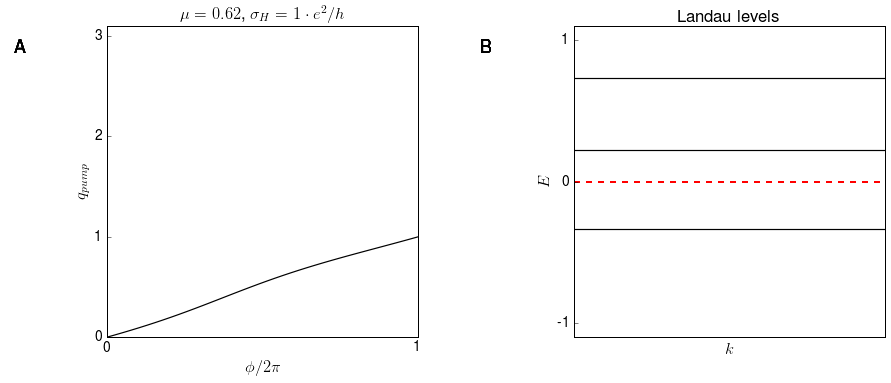
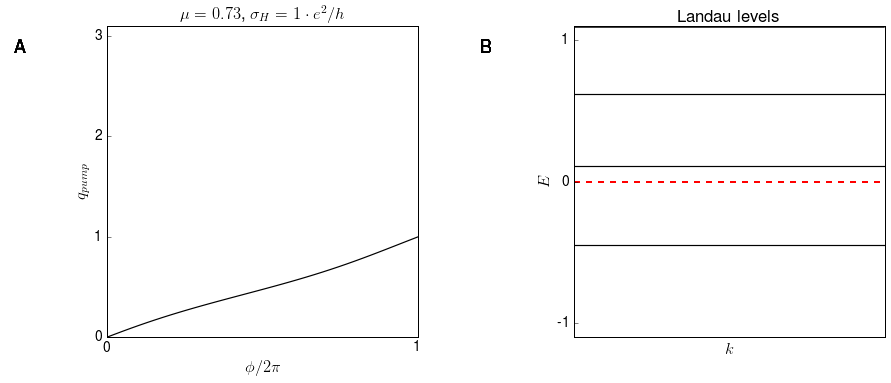
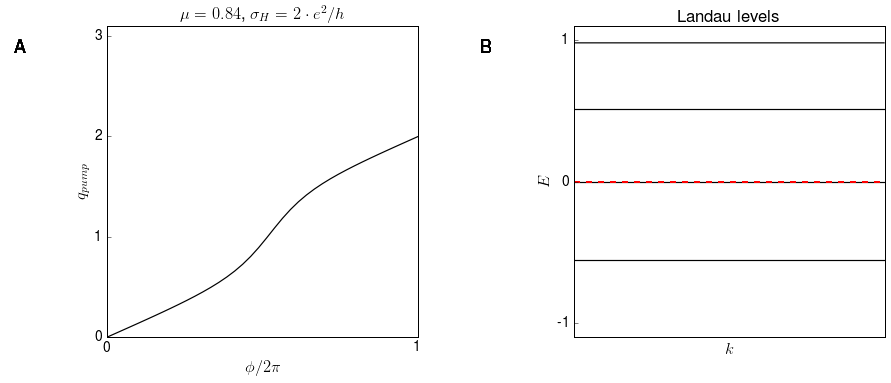
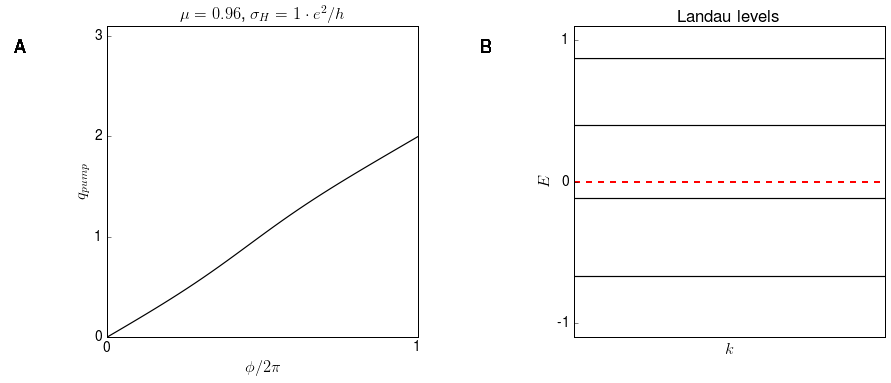
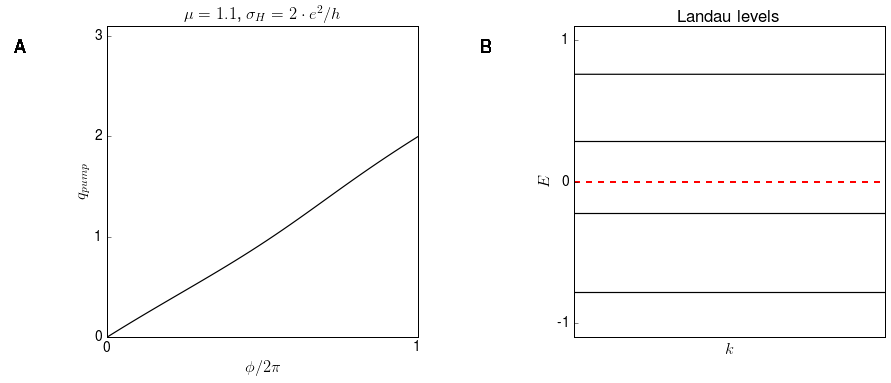
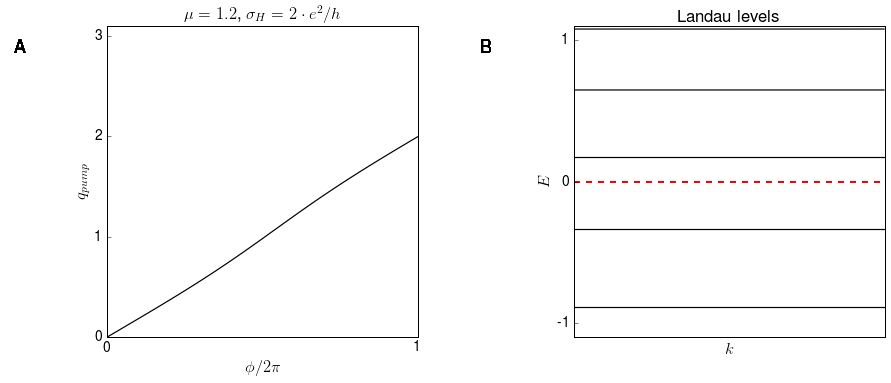
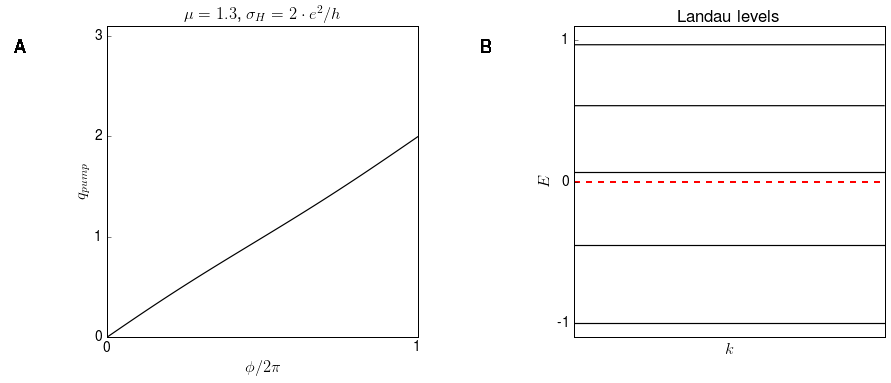
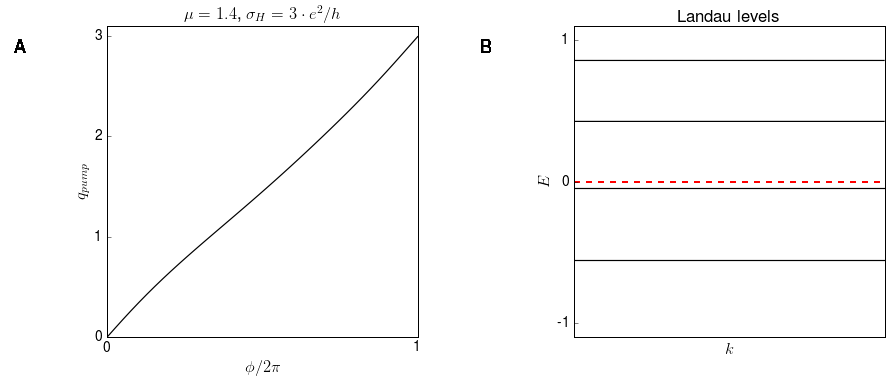

In [7]:
kwargs = {'ylims': [-1.1, 1.1],
          'xticks': 0,
          'yticks': [-1, 0, 1],
          'xdim': r'$k$',
          'ydim': r'$E$',
          'k_x': np.linspace(-np.pi, np.pi, 101),
          'title': lambda p: "Landau levels"}
W = 20
p = SimpleNamespace(t=1, B=2*np.pi/(W+1), phi=None, mu=None)
sys = qhe_corbino(r_out=2*W, r_in=20, w_lead=10)
sys1 = qhe_ribbon(W, True)
HLine = holoviews.HLine(0)(style={'linestyle': '--', 'color': 'r'})
mus = np.linspace(0.4, 1.4, 10)
hm1 = holoviews.HoloMap({p.mu: plot_pumping(sys, p) for p.mu in mus}, kdims=[r'$\mu$'])
hm2 = holoviews.HoloMap({p.mu: spectrum(sys1, p, **kwargs) for p.mu in mus}, kdims=[r'$\mu$'])
hm1 + hm2 * HLine

In [8]:
question = ("Consider a cylinder of height $W$, circumference $L$, subject to a magnetic field $B$, "
            "and with 2 Landau levels filled. "
            "Approximately, how many electrons does it contain?")
answers = ["$2.\,$",
           "$2 W/L\,.$",
           "$2 B WL / \Phi_0\, $.",
           "$ B L^2/\Phi_0\,$."]
explanation = "Based on the form of the Hamiltonian, $y$ goes from $0$ to $W$ and therefore $n$ goes from 0 to $B W L/\Phi_0$."
MoocMultipleChoiceAssessment(question, answers, correct_answer=2, explanation=explanation)

MoocMultipleChoiceAssessment(**{'question': 'Consider a cylinder of height $W$, circumference $L$, subject to a magnetic field $B$, and with 2 Landau levels filled. Approximately, how many electrons does it contain?', 'answers': ['$2.\\,$', '$2 W/L\\,.$', '$2 B WL / \\Phi_0\\, $.', '$ B L^2/\\Phi_0\\,$.'], 'max_attempts': 2, 'display_name': 'Question', 'explanation': 'Based on the form of the Hamiltonian, $y$ goes from $0$ to $W$ and therefore $n$ goes from 0 to $B W L/\\Phi_0$.', 'correct_answer': 2})

# Summary

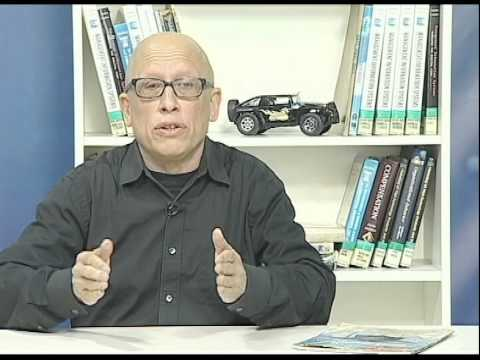

In [9]:
MoocVideo("2u8_2isyi7o", src_location='3.2-summary', res='360')

**Questions about what you learned? Ask them below**

In [10]:
MoocDiscussion("Questions", "Laughlin argument")

MoocDiscussion(**{'display_name': 'Laughlin argument', 'discussion_category': 'Questions', 'discussion_target': 'Laughlin argument', 'discussion_id': '274a4f6a5ece6fa10cf0c5e3d8ca2085'})